● Assignment 3, Part 1: Data Exploration. 
1) Load the training csv from the Kaggle Titanic dataset into a pandas dataframe. 
2) Document the columns that are missing data both numerically (via a count) and visually (via an sns heatmap). 
3) Document which values are categorical. 
4) Explore the data and answer the following questions: 
    * Did more women or men die on the Titanic? 
    * Which passenger class was more likely to survive? 
    * What does the distribution of fare look like? 
    * What does the distribution of non-null age values look like? 
    * What is the median age of each passenger class (pclass)? 
    * Visualize this in a box plot.


● Assignment 3, Part 2: Data Cleansing:
1) Since there are so many missing values in Cabin, get rid of the cabin feature. 
2) Define a function to impute age using the median of the passenger class you computed earlier. To call it, use train[[‘Age’,
‘Pclass]].apply(impute_age,axis=1). 
3) Drop the remaining records containing null values. 
4) Show there are no remaining null values. 
5) Convert categorical variables to numeric dummies using pandas’ get_dummies() method. 
6) Add these to your training dataframe. 
7) Drop the categorical columns you converted earlier as well as Name, Ticket, and PassengerId. 
8) Create a feature set by dropping “Survived.” Your resulting feature set should include Pclass, Age, SibSp, Parch, Fare, and
the categorical dummy columns you created earlier. 
9) Implement a label dataframe by copying the contents of the Survived column of your training set to a new
dataframe.


● Assignment 3, Part 3: Model Training. 

1) Implement a logistic regression model.
2) Implement a support vector classifier. 
3) Implement an sgd classifier. 
4) Print out the:
* classification reports, 
* confusion matrices, 
* roc score and chart for each of these. 

Remember to set Probability=True for SVM and use
method=decision_function in a cross_val_predict instead of predict_proba for the
SGD ROC plot.


● Assignment 3, Part 4: Model Tuning

1) See if scaling your input data affects your SVC model (implement a sklearn pipeline to combine scaling and instantiation of your model).
2) Do a grid search of your pipeline classifier using the following parameter grid: {‘linear_svc__kernel’: [‘rbf’], ‘linear_svc__gamma’: [0.0001, 0.001,0.01, 0.1, 1],‘linear_svc__C’: [1,10,50,100,200,300]}.
3) Print the:
* best estimator, 
* its parameters, 
* and the resulting score.
4) Implement a learning curve using your best estimator from the grid search.
* The figure should have a title of “learning curve.”
* Label the y-axis with “Score.”
* Label the x-axis with “Training Examples.”
* Make the training score red.
* Make the validation score green. 

5) What does this learning curve tell you?

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, svm, metrics, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import f1_score, make_scorer

# Assignment 3

## Part 1:

### Importing the data set and exploritory analysis

In [2]:
titanic_data_train = pd.read_csv("titanic_train.csv", index_col = 0)
titanic_data_test = pd.read_csv("titanic_test.csv" , index_col = 0)
titanic_test_target = pd.read_csv("titanic_test_target.csv", index_col = 0)

titanic_data_test = titanic_data_test.join(titanic_test_target)

total_train_population = titanic_data_train.shape[0]

In [3]:
titanic_data_train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_data_test.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In this data set we have categorical variables:
* Pclass
* Survived - target variable
* Sex
* Cabin
* Embarked
* Name
* Ticket

We also have numerical variables:
* Age
* Fare
* SibSp 
* Parch

It should be expected that name, ticket, and embarked would not affect the outcome variable.  Embarked could be associated with another predictable variable so we will leave in embarked.  Name and ticket will not be features in the final model as they are labels and not categorizing anything measurable.  It is also expected that fare and pclass will be correlated as one is the price of admission of the other.  

### Missing Data By Count: 

In [5]:
feature_names = titanic_data_train.columns

for name in feature_names:
    print(name, sum(titanic_data_train[name].isna()))

Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


### Missing Data Heatmap:

<AxesSubplot:ylabel='PassengerId'>

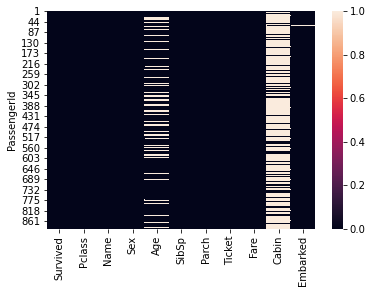

In [6]:
sb.heatmap(titanic_data_train.isna())

### Exploring Survivability by individual features:

In [7]:
titanic_survived_data = titanic_data_train[titanic_data_train.Survived == 1]
titanic_died_data = titanic_data_train[titanic_data_train.Survived == 0]

In [8]:
num_died_men = sum(titanic_died_data.Sex == "male")
num_died_women = sum(titanic_died_data.Sex == "female")

first_class_population = sum(titanic_data_train.Pclass == 1)
second_class_population = sum(titanic_data_train.Pclass == 2)
third_class_population = sum(titanic_data_train.Pclass == 3)

num_survived_first_class = sum(titanic_survived_data.Pclass == 1)
num_survived_second_class = sum(titanic_survived_data.Pclass == 2)
num_survived_third_class = sum(titanic_survived_data.Pclass == 3)

survival_probabilities_by_class = [

    num_survived_first_class / first_class_population , 
    num_survived_second_class / second_class_population, 
    num_survived_third_class / third_class_population

]

class_names = [

"First",
"Second",
"Third"

]

print("Men Deaths: ", num_died_men)
print("Women Deaths: ", num_died_women)



Men Deaths:  468
Women Deaths:  81


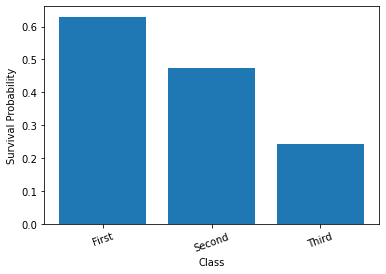

In [9]:
x = [i for i in range(0, len(class_names))]

plt.bar(x, survival_probabilities_by_class)
plt.xticks(ticks = x, labels = class_names, rotation = 20)
plt.xlabel("Class")
plt.ylabel("Survival Probability")
plt.show()

### Distribution of Numerical Variables: 

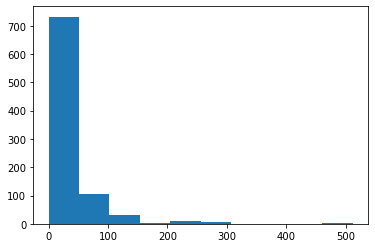

In [10]:
plt.hist(titanic_data_train.Fare)
plt.show()

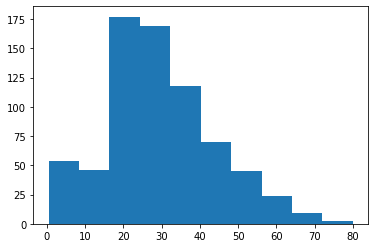

In [11]:
population_age = titanic_data_train.Age
population_age = population_age[population_age.isna() == False]

plt.hist(population_age)
plt.show()

Median First Class Age:  37.0
Median Second Class Age:  29.0
Median Third Class Age:  24.0


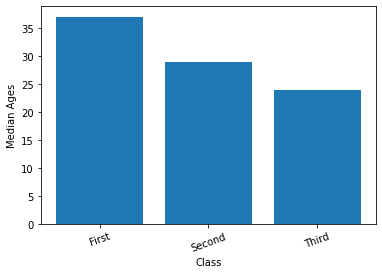

In [12]:
first_class_ages = population_age[titanic_data_train.Pclass == 1]
second_class_ages = population_age[titanic_data_train.Pclass == 2]
third_class_ages = population_age[titanic_data_train.Pclass == 3]

print("Median First Class Age: ", first_class_ages.median())
print("Median Second Class Age: ", second_class_ages.median())
print("Median Third Class Age: ", third_class_ages.median())

median_ages_by_class = [

    first_class_ages.median(),
    second_class_ages.median(),
    third_class_ages.median()

]

plt.bar(x, median_ages_by_class)
plt.xticks(ticks = x, labels = class_names, rotation = 20)
plt.xlabel("Class")
plt.ylabel("Median Ages")
plt.show()

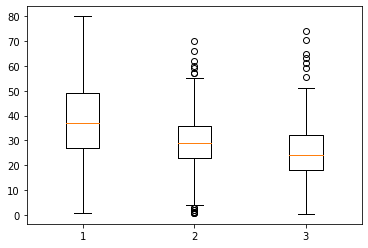

In [13]:
ages_series = [

    first_class_ages,
    second_class_ages,
    third_class_ages,
    
]

plt.boxplot(ages_series)
plt.show()

## Part 2: Data Cleaning

● Assignment 3, Part 2: Data Cleansing:
1) Since there are so many missing values in Cabin, get rid of the cabin feature. 
2) Define a function to impute age using the median of the passenger class you computed earlier. To call it, use train[[‘Age’,
‘Pclass]].apply(impute_age,axis=1). 
3) Drop the remaining records containing null values. 
4) Show there are no remaining null values. 
5) Convert categorical variables to numeric dummies using pandas’ get_dummies() method. 
6) Add these to your training dataframe. 
7) Drop the categorical columns you converted earlier as well as Name, Ticket, and Passenger Id. 
8) Create a feature set by dropping “Survived.” Your resulting feature set should include Pclass, Age, SibSp, Parch, Fare, and
the categorical dummy columns you created earlier. 
9) Implement a label dataframe by copying the contents of the Survived column of your training set to a new
dataframe.

### Dropping Cabin: 

In [14]:
titanic_data_train = titanic_data_train.drop(columns = ["Cabin"])
titanic_data_test = titanic_data_test.drop(columns = ["Cabin"])

### Replacing missing ages with the median values

In [15]:
def imputeMedianValue(data_frame, column):
    '''
    This function takes a pandas data frame and a column as a string and replaces all missing values with the median value of the non missing values of the column.
    '''

    ### First we calculate the median value:
    column_series = data_frame[column]
    column_without_na = column_series[column_series.isna() == False]
    median_value = column_without_na.median()

    ###Next we replace all na values with the median value
    data_frame[column] = data_frame[column].fillna(median_value)


In [16]:
imputeMedianValue(titanic_data_train, "Age")
imputeMedianValue(titanic_data_test, "Age")

### Removing rows with missing data

In [17]:
feature_names = titanic_data_train.columns
feature_names_test = titanic_data_test.columns


for name in feature_names:
    titanic_data_train = titanic_data_train[titanic_data_train[name].isna() == False]


for name in feature_names_test:
    titanic_data_test = titanic_data_test[titanic_data_test[name].isna() == False]

### Showing there are no more missing values with heatmaps

<AxesSubplot:ylabel='PassengerId'>

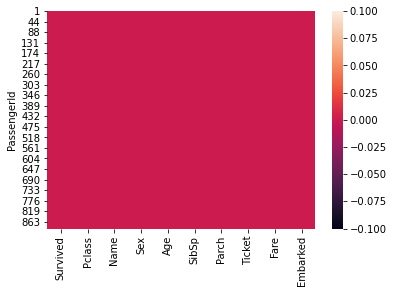

In [18]:
sb.heatmap(titanic_data_train.isna())


<AxesSubplot:ylabel='PassengerId'>

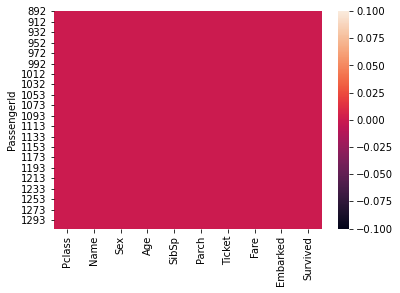

In [19]:
sb.heatmap(titanic_data_test.isna())

### Dropping non feature columns:

In [20]:
titanic_data_train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

In [21]:
non_feature_columns = ["Ticket", "Name"]

titanic_data_train = titanic_data_train.drop(columns = non_feature_columns)
titanic_data_test = titanic_data_test.drop(columns = non_feature_columns)

### Converting categorical variables to dummy numerics: 

In [22]:
titanic_data_train["Sex"] = pd.get_dummies(titanic_data_train.Sex)
titanic_data_train["Embarked"] = pd.get_dummies(titanic_data_train.Embarked)

titanic_data_test["Sex"] = pd.get_dummies(titanic_data_test.Sex)
titanic_data_test["Embarked"] = pd.get_dummies(titanic_data_test.Embarked)

In [23]:
titanic_data_train.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
408,1,2,0,3.0,1,1,18.7500,0
629,0,3,0,26.0,0,0,7.8958,0
517,1,2,1,34.0,0,0,10.5000,0
276,1,1,1,63.0,1,0,77.9583,0
399,0,2,0,23.0,0,0,10.5000,0
663,0,1,0,47.0,0,0,25.5875,0
378,0,1,0,27.0,0,2,211.5000,1
267,0,3,0,16.0,4,1,39.6875,0
849,0,2,0,28.0,0,1,33.0000,0


### Seperating the Target and Feature Variables: 

In [24]:
titanic_target_data = pd.DataFrame(titanic_data_train.Survived)
titanic_test_target = pd.DataFrame(titanic_data_test.Survived)

In [25]:
titanic_train_feature_data = titanic_data_train.drop(columns = ["Survived"])
titanic_data_test = titanic_data_test.drop(columns = ["Survived"])

## Part 3: Model Training

1) Implement a logistic regression model.
2) Implement a support vector classifier. 
3) Implement an sgd classifier. 
4) Print out the:
* classification reports, 
* confusion matrices, 
* roc score and chart for each of these. 

Remember to set Probability=True for SVM and use
method=decision_function in a cross_val_predict instead of predict_proba for the
SGD ROC plot.



### Creating the classifier objects. 

In [26]:
logistic_regression_classifier = linear_model.LogisticRegression(max_iter = 500)
support_vector_classifier = svm.SVC()
stochastic_gradient_classifier = linear_model.SGDClassifier()

### Fitting the data to the objects

In [27]:
logistic_model = logistic_regression_classifier.fit(titanic_train_feature_data, titanic_target_data.values.ravel())
support_vector_model = support_vector_classifier.fit(titanic_train_feature_data, titanic_target_data.values.ravel())
stochastic_gradient_model = stochastic_gradient_classifier.fit(titanic_train_feature_data, titanic_target_data.values.ravel())

### Making Predictions

In [28]:
logistic_survival_predictions = logistic_model.predict(titanic_data_test)
support_vector_predictions = support_vector_model.predict(titanic_data_test)
stochastic_gradient_predictions = stochastic_gradient_model.predict(titanic_data_test)

### Testing Predictions Against Test Data Results:

In [29]:
survived_actual = titanic_test_target.Survived

In [30]:
logistic_report = metrics.classification_report(survived_actual, logistic_survival_predictions)
print(logistic_report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       265
           1       0.91      0.95      0.93       152

    accuracy                           0.95       417
   macro avg       0.94      0.95      0.94       417
weighted avg       0.95      0.95      0.95       417



In [31]:
support_vecor_report = metrics.classification_report(survived_actual, support_vector_predictions)
print(support_vecor_report)

              precision    recall  f1-score   support

           0       0.68      0.87      0.76       265
           1       0.55      0.27      0.36       152

    accuracy                           0.65       417
   macro avg       0.61      0.57      0.56       417
weighted avg       0.63      0.65      0.62       417



In [32]:
stochastic_gradient_report = metrics.classification_report(survived_actual, stochastic_gradient_predictions)
print(stochastic_gradient_report)

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       265
           1       0.68      0.97      0.80       152

    accuracy                           0.82       417
   macro avg       0.83      0.85      0.82       417
weighted avg       0.87      0.82      0.83       417



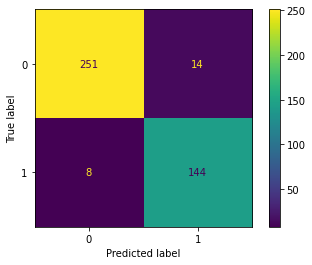

In [33]:
metrics.plot_confusion_matrix(logistic_regression_classifier, titanic_data_test, survived_actual)

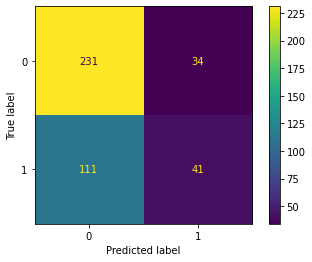

In [34]:
metrics.plot_confusion_matrix(support_vector_classifier, titanic_data_test, survived_actual)

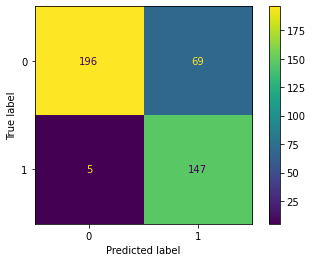

In [35]:
metrics.plot_confusion_matrix(stochastic_gradient_classifier, titanic_data_test, survived_actual)

In [36]:
logistic_roc = metrics.roc_auc_score(survived_actual, logistic_survival_predictions)
support_vector_roc = metrics.roc_auc_score(survived_actual, support_vector_predictions)
stochastic_gradient_roc = metrics.roc_auc_score(survived_actual, stochastic_gradient_predictions)

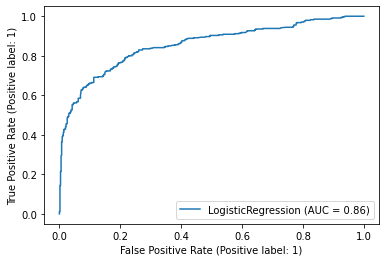

In [37]:
metrics.plot_roc_curve(logistic_regression_classifier, titanic_train_feature_data, titanic_target_data)

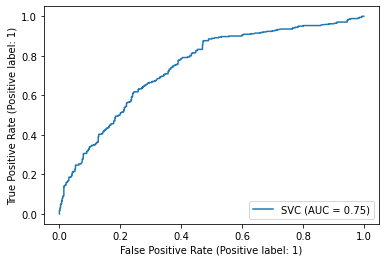

In [38]:
metrics.plot_roc_curve(support_vector_classifier, titanic_train_feature_data, titanic_target_data)

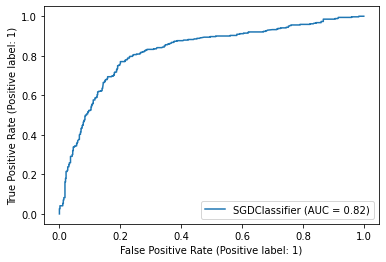

In [39]:
metrics.plot_roc_curve(stochastic_gradient_classifier, titanic_train_feature_data, titanic_target_data)

In [40]:
print("logistic roc ", logistic_roc)
print("support vector roc ", support_vector_roc)
print("stochastic gradient roc ", stochastic_gradient_roc)

logistic roc  0.9472691161866931
support vector roc  0.5707174776564052
stochastic gradient roc  0.8533639523336644


As we see with the AUC score, the scores are consistant with our previous metrics.  The support vector model shows almost no distinguishability, the stochastic gradient model is adequate, but the logistic regression model shows great predictability of an AUC score of around 1.  

## Assignment 3, Part 4: Model Tuning

1) See if scaling your input data affects your SVC model (implement a sklearn pipeline to combine scaling and instantiation of your model).
2) Do a grid search of your pipeline classifier using the following parameter grid: {‘linear_svc__kernel’: [‘rbf’], ‘linear_svc__gamma’: [0.0001, 0.001,0.01, 0.1, 1],‘linear_svc__C’: [1,10,50,100,200,300]}.
3) Print the:
* best estimator, 
* its parameters, 
* and the resulting score.
4) Implement a learning curve using your best estimator from the grid search.
* The figure should have a title of “learning curve.”
* Label the y-axis with “Score.”
* Label the x-axis with “Training Examples.”
* Make the training score red.
* Make the validation score green. 

5) What does this learning curve tell you?

In [41]:
titanic_scaled_train = preprocessing.scale(titanic_train_feature_data)
titanic_scaled_train = pd.DataFrame(data = titanic_scaled_train, columns = titanic_train_feature_data.columns)

titanic_scaled_train.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.825209,-0.735342,-0.563674,0.431350,-0.474326,-0.500240,-0.482711
1,-1.572211,1.359911,0.669217,0.431350,-0.474326,0.788947,2.071634
2,0.825209,1.359911,-0.255451,-0.475199,-0.474326,-0.486650,-0.482711
3,-1.572211,1.359911,0.438050,0.431350,-0.474326,0.422861,-0.482711
4,0.825209,-0.735342,0.438050,-0.475199,-0.474326,-0.484133,-0.482711


In [42]:
svc_pipeline = Pipeline([("scale", preprocessing.StandardScaler()), ("Support Vector Classifier", svm.SVC())])
svc_pipeline_model = svc_pipeline.fit(titanic_train_feature_data, titanic_target_data.values.ravel())


In [43]:
grid_search_parameters = {"Support Vector Classifier__kernel": ["rbf"], "Support Vector Classifier__gamma": [0.0001, 0.001,0.01, 0.1, 1], "Support Vector Classifier__C": [1,10,50,100,200,300]} 

grid_search_scorer = make_scorer(f1_score)

support_vector_grid_search = GridSearchCV(svc_pipeline, grid_search_parameters, scoring = grid_search_scorer)

In [44]:
support_vector_grid_search_model = support_vector_grid_search.fit(titanic_train_feature_data, titanic_target_data.values.ravel())

In [45]:
support_vector_grid_search_model.best_params_

{'Support Vector Classifier__C': 300,
 'Support Vector Classifier__gamma': 0.01,
 'Support Vector Classifier__kernel': 'rbf'}

In [46]:
support_vector_grid_search_model.best_score_

0.7621546096115501

### Implamenting the Learning Curve

In [47]:
svm_learning_curve = learning_curve(support_vector_grid_search_model, titanic_train_feature_data, titanic_target_data.values.ravel())

In [48]:
## coppied from sklearn doccumentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html  
# 
# I don't know why this isn't just a built in function

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

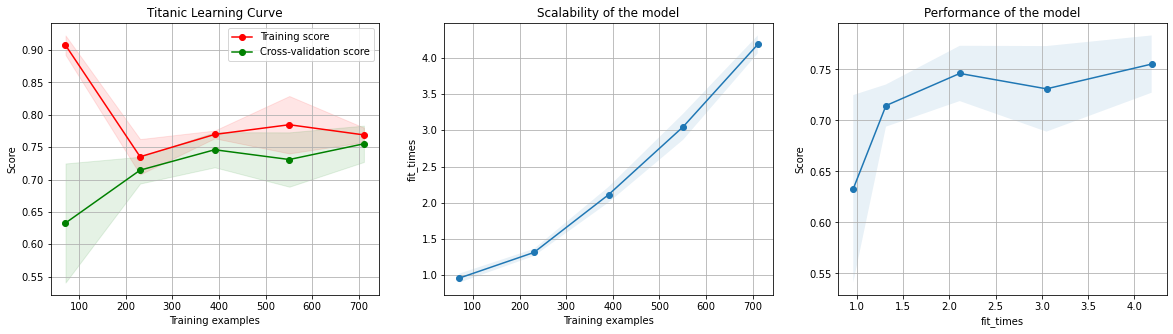

In [49]:
plot_learning_curve(support_vector_grid_search_model, "Titanic Learning Curve", titanic_train_feature_data, titanic_target_data.values.ravel())

The learning curve displays the bias/variance trade off.  Here from our left most plot, we can see that we get the greatest increase in performance from 50 to 225.  We can infer then that our model will perform best with around 225 points of training data.  